# **Project 02**

---
Author: Chen Siyi, Kim Minjung



# Import Packages


In [1]:
pip install SimpleITK

     |████████████████████████████████| 48.4 MB 5.0 kB/s 


In [ ]:
!pip3 install torch==1.10.0

  Using cached torch-1.10.0-cp37-cp37m-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.10.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.10.0 which is incompatible.


In [2]:
import glob
import os 
from pathlib import Path
import random

from PIL import Image
import numpy as np
import pandas  as pd
import nibabel as nib
import matplotlib.pyplot as plt

import SimpleITK as sitk

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models
import torchvision.transforms.functional as TF

In [3]:
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 31 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning
import os
from nibabel.testing import data_path

In [5]:
import ipywidgets

In [6]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-f5x0hmb5
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-f5x0hmb5
     |████████████████████████████████| 58 kB 2.9 MB/s 
     |████████████████████████████████| 376 kB 10.6 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88601 sha256=056b23d9c9306fce86824967987efeb1cb57af8ae976b6f55c72d5aa0b08eac3
  Stored in directory: /tmp/pip-ephem-wheel-cache-gqp2bi02/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4b55d5436eb52c2674990f58ae9137c18c1d9195b5408fbe86495ecf9c7146ac
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

# Load and Read Data
1.   sitk.ReadImage
2.   sitk.GetArrayFromImage

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_dir = Path('drive/MyDrive/E_Lungs')

In [9]:
def read_nii(filepath, sl=None):
    '''
    Reads .nii volume file and returns pixel array for slice sl
    '''
    sample_ct = nib.load(str(filepath))
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    if sl != None:
        array = sample_ct.dataobj[:,:,sl]
        array = np.rot90(array)
    else:
        array = sample_ct.dataobj
        array = np.rot90(array)
    return(array)    


# Data List

1.   python's enumerate: https://realpython.com/python-enumerate/
2.   scikit-learn's train_test_split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
*   20% as test data
*   10% as validation data
*   70% as train data
2.   random.choices: choose k data randomly

In [10]:
def read_slices(all_data):
    '''
    Reads the slices and creates a list of tuples, containing one row per slice in the format [image, mask, slice number]
    '''
    filename_slices = []
    for idx, fn_data in enumerate(all_data):
        fn_mask = Path(str(fn_data).replace('org_', ''))
        fn_mask = Path(str(fn_mask).replace('covid-19-pneumonia-', ''))
        fn_mask = Path(str(fn_mask).replace('-dcm', ''))
        fn_lung_mask = Path(str(fn_mask).replace('ct_scans', 'lung_mask'))
        fn_infection_mask = Path(str(fn_mask).replace('ct_scans', 'infection_mask'))
        data = read_nii(fn_lung_mask)
        for sl in range(data.shape[2]):
            if np.sum(data[:,:,sl]) > 5000:
                filename_slices += [(fn_data, fn_lung_mask, fn_infection_mask, sl)]
    return filename_slices

In [11]:
#
#  Get the list of all the masks
#

# filenames_mask = list(data_dir.glob('ct_scans/coronacases*.nii'))
filenames_mask = list(data_dir.glob('ct_scans/*.nii'))
print(f'Total number of masks: {len(filenames_mask)}')

#
# Split into the training, validation and test splits using scikit-learn's train_test_split function. 
# Also, check to see how many are in each to make sure that it makes sense.
#

# tt, test_filenames = train_test_split(filenames_mask, test_size = 0.2)
# train_filenames, val_filenames = train_test_split(tt, test_size = 0.2) #we split the temporary variables in an 80/20 partition

tt, test_filenames = train_test_split(filenames_mask, test_size = 0.2)
train_filenames, val_filenames = train_test_split(tt, test_size = 0.125) 

print(f'Number of training data: {len(train_filenames)}')
print(f'Number of validation data: {len(val_filenames)}')
print(f'Number of test data: {len(test_filenames)}')

Total number of masks: 20
Number of training data: 14
Number of validation data: 2
Number of test data: 4


In [19]:
train_file_slices = read_slices(train_filenames)
val_file_slices = read_slices(val_filenames)
test_file_slices = read_slices(test_filenames)

print(f'Number of training slices: {len(train_file_slices)}')
print(f'Number of validation slices: {len(val_file_slices)}')
print(f'Number of test slices: {len(test_file_slices)}')

print(f'First few training items: ')
for tfs in train_file_slices[:3]:
    print(tfs)

Number of training slices: 1914
Number of validation slices: 380
Number of test slices: 445
First few training items: 
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_001.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_001.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_001.nii'), 68)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_001.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_001.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_001.nii'), 69)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_001.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_001.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_001.nii'), 70)


In [20]:
train_file_slices = random.choices(train_file_slices,k=500)
val_file_slices = random.choices(val_file_slices, k=50)
test_file_slices = random.choices(test_file_slices, k=100)
print(f'{test_file_slices[0]}')
print(f'{test_file_slices[1]}')
print(f'{test_file_slices[2]}')

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_006.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_006.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_006.nii'), 145)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_009.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_009.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_009.nii'), 158)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_009.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_009.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_009.nii'), 148)


# Display Image

Text(0.5, 1.0, 'Infection Mask')

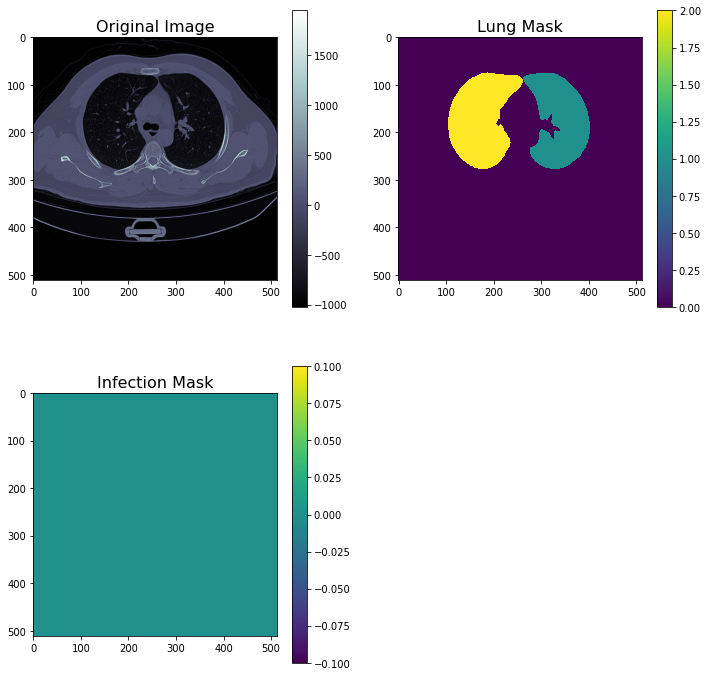

In [24]:
# Get the filenames and slice from the structure
fn, fn_lung_mask, fn_infection_mask, sl = test_file_slices[0]

# Load the data using the loading function that will be used later
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)

# Plot the data, and make it look nice, you will probably use this in a paper
fig = plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.imshow(sample_ct, cmap='bone')
plt.colorbar()
plt.title('Original Image', fontsize=16)
plt.subplot(2,2,2)
plt.imshow(sample_lung_mask, interpolation='none')
plt.colorbar()
plt.title('Lung Mask', fontsize=16)
plt.subplot(2,2,3)
plt.imshow(sample_infection_mask, interpolation='none')
plt.colorbar()
plt.title('Infection Mask', fontsize=16)

# **Image Intensity-Based (Threshold) Segmentation**

---



In [ ]:
def imstrip(images, **imshow_args):
    """View multiple images side by side."""
    import numpy as np
    from matplotlib import pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=[5*len(images),4])
    axs = ImageGrid(fig, 111, nrows_ncols=[1,len(images)], axes_pad=0.9, cbar_mode='each', cbar_pad=0.1)
    for i, image in enumerate(images):
        kwargs = imshow_args.copy()
        kwargs.setdefault('cmap', 'gray')
        kwargs.setdefault('clim', np.percentile(np.array(image, dtype=np.float32), [1,99]))
        im = axs[i].imshow(image, **kwargs)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        fig.colorbar(im, cax=axs.cbar_axes[i])
    return axs

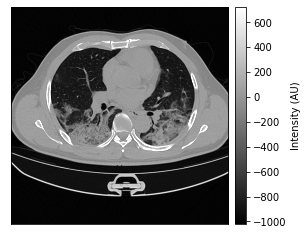

In [ ]:
axs = imstrip([sample_ct])
axs[0].images[0].colorbar.set_label('Intensity (AU)')

In [ ]:
@ipywidgets.interact(threshold=(sample_ct.min(), sample_ct.max()))
def threshold(threshold=np.percentile(sample_ct, 75)):
    thresholded = sample_ct < threshold
    fig, axs = plt.subplots(ncols=2, figsize=[9,4])

    # left axis
    axs[0].hist(np.ravel(sample_ct), bins=50)
    axs[0].axvline(threshold, color='C1')
    axs[0].set_xlabel('Intensity')
    axs[0].set_ylabel('Count')

    # right axis
    im = axs[1].imshow(thresholded, cmap='gray')
    axs[1].set_xticks([])
    axs[1].set_yticks([])


interactive(children=(IntSlider(value=-12, description='threshold', max=1993, min=-1023), Output()), _dom_clas…

In [73]:
from skimage.morphology import binary_erosion, binary_dilation, disk
from scipy.ndimage import generate_binary_structure
from skimage.morphology import label
from skimage.measure import regionprops
from scipy.ndimage.morphology import binary_fill_holes
from skimage.segmentation import clear_border
from skimage.segmentation import watershed
 
def largest_connected_component(image, connectivity=2):
   """Label image and return label with largest area."""
   labels = label(image)
   props = regionprops(labels)
   indices = np.argsort([prop.area for prop in props]) + 1
   return labels == indices[-1]
 
def strip_skull(image, threshold=-500, dilation=4):
   """Threshold-based skull stripping."""
   bone_tissue = image < threshold
   cranium = largest_connected_component(bone_tissue)  # defined above
   cranium_plus = binary_dilation(cranium, disk(dilation))
   brain = image.copy()
   brain[cranium_plus == 1] = brain.min()
   return brain
 
def second_largest_connected_component(image, connectivity=2):
   """Label image and return label with largest area."""
   labels = label(image)
   props = regionprops(labels)
   indices = np.argsort([prop.area for prop in props]) + 1
   return labels == indices[-2]
 
def dice_coef(y_true, y_pred):
   """
   Compute the Dice coefficient between two N-D masks.
   """
 
   # Convert the input to a numpy array if it is a torch Tensor
   if isinstance(y_true, torch.Tensor):
       y_true = y_true.cpu().detach().numpy()
  
   if isinstance(y_pred, torch.Tensor):
       y_pred = y_pred.cpu().detach().numpy()
  
   y_true_f = y_true.flatten()
   y_pred_f = y_pred.flatten()
   intersection = np.sum(y_true_f * y_pred_f)
   smooth = 0.0001
   return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

No handles with labels found to put in legend.


0.9724298201964378
-329
0.9724298201964378


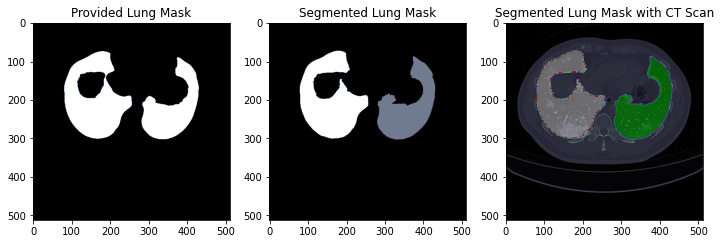

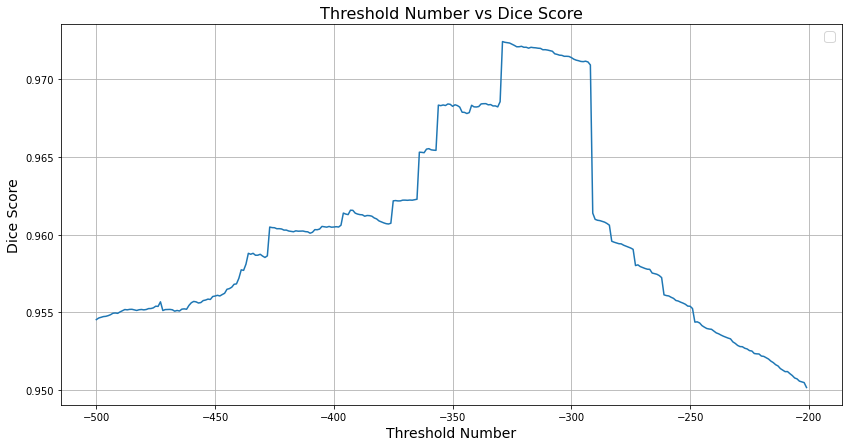

In [72]:
sample_ct = read_nii('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_008.nii', 90)
sample_lung_mask = read_nii('drive/MyDrive/E_Lungs/lung_mask/coronacases_008.nii', 90)
 
struct = generate_binary_structure(2, 1)
dice_array = []
max_dice = -1000
s_thres = 0
for thres_num in range(-500,-200):
 thresholded = strip_skull(sample_ct) < thres_num 
 lungs = clear_border(thresholded)
 largest = largest_connected_component(lungs)
 largest_2 = second_largest_connected_component(lungs)
 largest = largest*2
 lung_dilate1 = binary_dilation(largest,struct)
 lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
 lung_dilate1 = lung_dilate1 * 2
 
 lung_dilate2 = binary_dilation(largest_2,struct)
 lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
 lung_total = lung_dilate1 + lung_dilate2
 sample_lung_mask = sample_lung_mask.astype(bool)
 lung_total = lung_total.astype(bool)
 new_dice = dice_coef(sample_lung_mask,lung_total)
 tuplething = [thres_num, new_dice]
 dice_array.append(tuplething)
 if max_dice < new_dice:
   max_dice = new_dice
   s_thres = thres_num
print(max_dice)
print(s_thres)
thresholded = strip_skull(sample_ct) < s_thres
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2
 
lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2
fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')
 
plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')
 
plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')
 
sample_lung_mask = sample_lung_mask.astype(bool)
lung_total = lung_total.astype(bool)
print(dice_coef(sample_lung_mask,lung_total))
dice_array = np.asarray(dice_array)

fig = plt.figure(figsize=(14, 7))
plt.plot(dice_array[:,0],dice_array[:,1])
plt.xlabel('Threshold Number', fontsize=14)
plt.ylabel('Dice Score', fontsize=14)
plt.title('Threshold Number vs Dice Score', fontsize=16)
# plt.xticks(range(thres_num))
plt.grid('on')
plt.legend(fontsize=14)

# **Neural Network Segmentation**

---



# Set Hyper Parameters

In [25]:
batch_size = 8
epochs = 10

# GPU Setup

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')

if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')

Device is cpu


# Transformation and Data Augmentation


1.   albumentations: https://albumentations.ai/
2.   from albumentations.pytorch import ToTensorV2


In [27]:
#
# Transformtions to be applied to the training set - This is using Albumentations
#

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

In [28]:
#
# Transformtions to be applied to the validation and testing sets - this is using Albumentations
#

test_transform = A.Compose(
    [
        A.Resize(256, 256), 
        ToTensorV2()]
)

# Dataset and Data Loader

In [29]:
#
# Create the Dataset class specific for this work.
# pytorch

class LungDataset(Dataset):
    
    def __init__(self, filename_slices, transform):
        """
        Initialized
        """
        super().__init__()

        # Store variables we are interested in...
        self._filename_slices = filename_slices 
        self._transform = transform    

    def __getitem__(self, index):

        """
        Get a single image / label pair.
        """
        #
        # Read in the image
        #

        fn, fn_lung_mask, fn_infection_mask, sl = self._filename_slices[index]
        
        image = read_nii(fn, sl)
        mm , MM = np.min(image), np.max(image)
        image = (image - mm) / (MM - mm) * 255 #Ensure input is between 0-255
        image = np.array(image, dtype=np.float32)
        
        #
        # Read in the lung mask
        #
        lung_mask = read_nii(fn_lung_mask, sl).astype(np.bool)
        lung_mask = lung_mask.astype(np.int8)
        # lung_mask = read_nii(fn_lung_mask, sl).astype(np.int8)
        #
        # Data augmentation 
        #
        if self._transform is not None:
            augmented = self._transform(image=image, mask=lung_mask)
            image = augmented['image']
            lung_mask = augmented['mask']
        
        #
        # Return the image mask pair
        #
        return image, lung_mask
    
    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filename_slices)

class InfectionDataset(Dataset):
    
    def __init__(self, filename_slices, transform):
        """
        Initialized
        """
        super().__init__()

        # Store variables we are interested in...
        self._filename_slices = filename_slices 
        self._transform = transform    

    def __getitem__(self, index):

        """
        Get a single image / label pair.
        """
        #
        # Read in the image
        #

        fn, fn_lung_mask, fn_infection_mask, sl = self._filename_slices[index]
        
        image = read_nii(fn, sl)
        mm , MM = np.min(image), np.max(image)
        image = (image - mm) / (MM - mm) * 255 #Ensure input is between 0-255
        image = np.array(image, dtype=np.float32)
      

        #
        # Read in the infection mask
        #
        infection_mask = read_nii(fn_infection_mask, sl).astype(np.int8)

        #
        # Data augmentation 
        #
        if self._transform is not None:
            augmented = self._transform(image=image, mask=infection_mask)
            image = augmented['image']
            infection_mask = augmented['mask']
            # preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')       
        #
        # Return the image mask pair
        #
        return image, infection_mask
    
    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filename_slices)

In [31]:
# Create the datsets and dataloaders for every subset 

train_Lung_dataset = LungDataset(train_file_slices, train_transform)
train_Infection_dataset = InfectionDataset(train_file_slices, train_transform)

train_Lung_dataloader = DataLoader(train_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
train_Infection_dataloader = DataLoader(train_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 

val_Lung_dataset = LungDataset(val_file_slices, test_transform)
val_Infection_dataset = InfectionDataset(val_file_slices, test_transform)

val_Lung_dataloader = DataLoader(val_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
val_Infection_dataloader = DataLoader(val_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 

test_Lung_dataset = LungDataset(test_file_slices, test_transform)
test_Infection_dataset = InfectionDataset(test_file_slices, test_transform)

test_Lung_dataloader = DataLoader(test_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=False) 
test_Infection_dataloader = DataLoader(test_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=False) 

# Dataloader Visualization


1.   iter and next: https://www.programiz.com/python-programming/methods/built-in/iter



Text(0.5, 1.0, 'Infection_Mask')

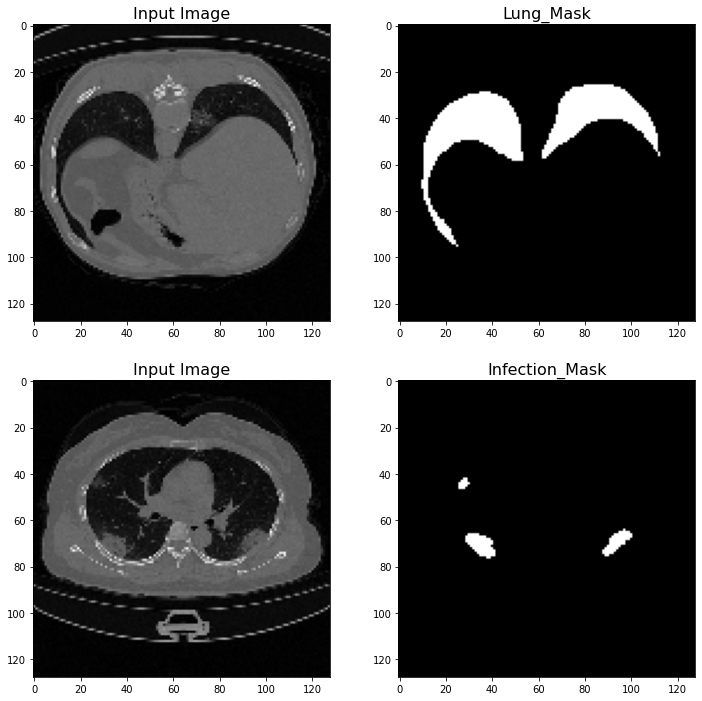

In [ ]:
image1, lung_mask = next(iter(train_Lung_dataloader))
image2, infection_mask = next(iter(train_Infection_dataloader))

fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(image1[1,0])
plt.title('Input Image', fontsize=16)
plt.gray()
plt.subplot(2,2,2)
plt.imshow(lung_mask[1])
plt.title('Lung_Mask', fontsize=16)
plt.subplot(2,2,3)
plt.imshow(image2[1,0])
plt.title('Input Image', fontsize=16)
plt.gray()
plt.subplot(2,2,4)
plt.imshow(infection_mask[1])
plt.title('Infection_Mask', fontsize=16)

# U-Net Architecture (without pre-train)

In [ ]:
class contracting(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(512, 1024, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(1024, 1024, 3, stride=1, padding=1), nn.ReLU())

        self.down_sample = nn.MaxPool2d(2, stride=2)


    def forward(self, X):
        X1 = self.layer1(X)
        X2 = self.layer2(self.down_sample(X1))
        X3 = self.layer3(self.down_sample(X2))
        X4 = self.layer4(self.down_sample(X3))
        X5 = self.layer5(self.down_sample(X4))
        return X5, X4, X3, X2, X1


class expansive(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(64, 2, 3, stride=1, padding=1)

        self.layer2 = nn.Sequential(nn.Conv2d(128, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(256, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(1024, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.up_sample_54 = nn.ConvTranspose2d(1024, 512, 2, stride=2)

        self.up_sample_43 = nn.ConvTranspose2d(512, 256, 2, stride=2)

        self.up_sample_32 = nn.ConvTranspose2d(256, 128, 2, stride=2)

        self.up_sample_21 = nn.ConvTranspose2d(128, 64, 2, stride=2)


    def forward(self, X5, X4, X3, X2, X1):
        X = self.up_sample_54(X5)
        X4 = torch.cat([X, X4], dim=1)
        X4 = self.layer5(X4)

        X = self.up_sample_43(X4)
        X3 = torch.cat([X, X3], dim=1)
        X3 = self.layer4(X3)

        X = self.up_sample_32(X3)
        X2 = torch.cat([X, X2], dim=1)
        X2 = self.layer3(X2)

        X = self.up_sample_21(X2)
        X1 = torch.cat([X, X1], dim=1)
        X1 = self.layer2(X1)

        X = self.layer1(X1)

        return X


class unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.down = contracting()
        
        # Decoder
        self.up = expansive()

    def forward(self, X):
        # Encoder
        X5, X4, X3, X2, X1 = self.down(X)
        
        # Decoder
        X = self.up(X5, X4, X3, X2, X1)
        return X
        #F.softmax(X, dim=1)
    

# Train the Neural Network (with pre-train)


In [32]:
#
# Load the model
#

# with pre-train
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
# without pre-train
# model = unet()
model.to(device)

#
# Create the optimizer
#
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#
# Create the loss function
#
loss = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [33]:
def dice_coef(y_true, y_pred):
    """
    Compute the Dice coefficient between two N-D masks.
    """

    # Convert the input to a numpy array if it is a torch Tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
    
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Training (Lung Mask)

Epoch 0 / 10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


	Batch 0 loss 1.505
	Batch 1 loss 1.423
	Batch 2 loss 1.425
	Batch 3 loss 1.383
	Batch 4 loss 1.274
	Batch 5 loss 1.213
	Batch 6 loss 1.399
	Batch 7 loss 1.174
	Batch 8 loss 1.088
	Batch 9 loss 1.057
	Batch 10 loss 1.015
	Batch 11 loss 0.989
	Batch 12 loss 0.979
	Batch 13 loss 0.897
	Batch 14 loss 0.871
	Batch 15 loss 0.907
	Batch 16 loss 0.848
	Batch 17 loss 0.808
	Batch 18 loss 0.780
	Batch 19 loss 0.767
	Batch 20 loss 0.811
	Batch 21 loss 0.740
	Batch 22 loss 0.724
	Batch 23 loss 0.691
	Batch 24 loss 0.691
	Batch 25 loss 0.674
	Batch 26 loss 0.719
	Batch 27 loss 0.661
	Batch 28 loss 0.653
	Batch 29 loss 0.639
	Batch 30 loss 0.626
	Batch 31 loss 0.648
	Batch 32 loss 0.643
	Batch 33 loss 0.619
	Batch 34 loss 0.608
	Batch 35 loss 0.601
	Batch 36 loss 0.594
	Batch 37 loss 0.620
	Batch 38 loss 0.592
	Batch 39 loss 0.593
	Batch 40 loss 0.593
	Batch 41 loss 0.589
	Batch 42 loss 0.645
	Batch 43 loss 0.541
	Batch 44 loss 0.576
	Batch 45 loss 0.560
	Batch 46 loss 0.542
	Batch 47 loss 0.557
	B

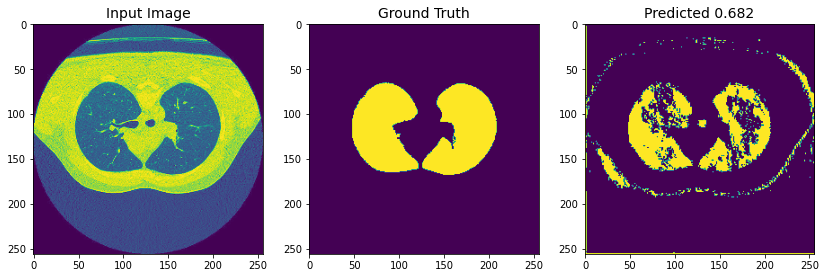

	Batch  1 0.45764675736427307
	Batch  2 0.46101000905036926
	Batch  3 0.4473715126514435
	Batch  4 0.4641745686531067
	Batch  5 0.46323227882385254
	Batch  6 0.44937920570373535
Validation Loss: 0.460, Accuracy: 0.690
Epoch 1 / 10
	Batch 0 loss 0.477
	Batch 1 loss 0.448
	Batch 2 loss 0.468
	Batch 3 loss 0.461
	Batch 4 loss 0.470
	Batch 5 loss 0.428
	Batch 6 loss 0.495
	Batch 7 loss 0.441
	Batch 8 loss 0.465
	Batch 9 loss 0.452
	Batch 10 loss 0.441
	Batch 11 loss 0.448
	Batch 12 loss 0.417
	Batch 13 loss 0.435
	Batch 14 loss 0.398
	Batch 15 loss 0.405
	Batch 16 loss 0.464
	Batch 17 loss 0.390
	Batch 18 loss 0.428
	Batch 19 loss 0.377
	Batch 20 loss 0.408
	Batch 21 loss 0.394
	Batch 22 loss 0.402
	Batch 23 loss 0.379
	Batch 24 loss 0.389
	Batch 25 loss 0.360
	Batch 26 loss 0.367
	Batch 27 loss 0.376
	Batch 28 loss 0.352
	Batch 29 loss 0.349
	Batch 30 loss 0.382
	Batch 31 loss 0.342
	Batch 32 loss 0.373
	Batch 33 loss 0.374
	Batch 34 loss 0.338
	Batch 35 loss 0.330
	Batch 36 loss 0.367
	B

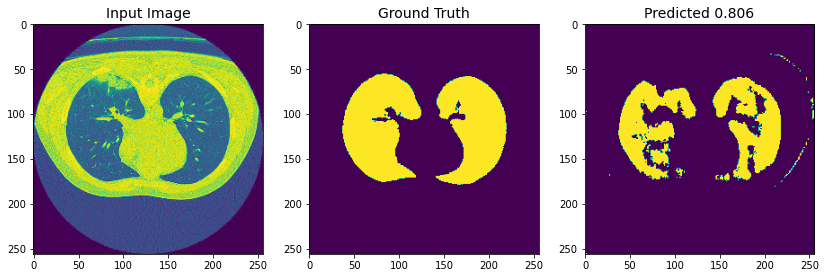

	Batch  1 0.3027212917804718
	Batch  2 0.30382397770881653
	Batch  3 0.3088522255420685
	Batch  4 0.322155237197876
	Batch  5 0.3149479627609253
	Batch  6 0.31643298268318176
Validation Loss: 0.308, Accuracy: 0.739
Epoch 2 / 10
	Batch 0 loss 0.274
	Batch 1 loss 0.281
	Batch 2 loss 0.260
	Batch 3 loss 0.252
	Batch 4 loss 0.251
	Batch 5 loss 0.267
	Batch 6 loss 0.243
	Batch 7 loss 0.262
	Batch 8 loss 0.248
	Batch 9 loss 0.228
	Batch 10 loss 0.245
	Batch 11 loss 0.230
	Batch 12 loss 0.252
	Batch 13 loss 0.247
	Batch 14 loss 0.222
	Batch 15 loss 0.238
	Batch 16 loss 0.226
	Batch 17 loss 0.244
	Batch 18 loss 0.219
	Batch 19 loss 0.223
	Batch 20 loss 0.213
	Batch 21 loss 0.228
	Batch 22 loss 0.211
	Batch 23 loss 0.213
	Batch 24 loss 0.209
	Batch 25 loss 0.215
	Batch 26 loss 0.218
	Batch 27 loss 0.232
	Batch 28 loss 0.211
	Batch 29 loss 0.203
	Batch 30 loss 0.217
	Batch 31 loss 0.245
	Batch 32 loss 0.198
	Batch 33 loss 0.215
	Batch 34 loss 0.198
	Batch 35 loss 0.213
	Batch 36 loss 0.199
	Batc

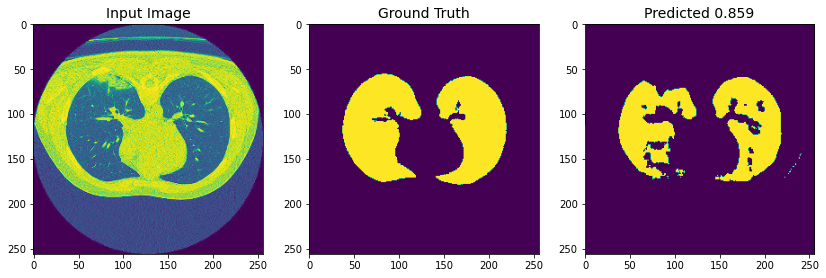

	Batch  1 0.23310306668281555
	Batch  2 0.20753858983516693
	Batch  3 0.22412462532520294
	Batch  4 0.2096671611070633
	Batch  5 0.22174805402755737
	Batch  6 0.24699781835079193
Validation Loss: 0.221, Accuracy: 0.823
Epoch 3 / 10
	Batch 0 loss 0.180
	Batch 1 loss 0.176
	Batch 2 loss 0.192
	Batch 3 loss 0.171
	Batch 4 loss 0.171
	Batch 5 loss 0.168
	Batch 6 loss 0.174
	Batch 7 loss 0.185
	Batch 8 loss 0.173
	Batch 9 loss 0.180
	Batch 10 loss 0.161
	Batch 11 loss 0.162
	Batch 12 loss 0.172
	Batch 13 loss 0.163
	Batch 14 loss 0.177
	Batch 15 loss 0.211
	Batch 16 loss 0.157
	Batch 17 loss 0.160
	Batch 18 loss 0.157
	Batch 19 loss 0.159
	Batch 20 loss 0.176
	Batch 21 loss 0.181
	Batch 22 loss 0.166
	Batch 23 loss 0.152
	Batch 24 loss 0.148
	Batch 25 loss 0.156
	Batch 26 loss 0.162
	Batch 27 loss 0.152
	Batch 28 loss 0.145
	Batch 29 loss 0.151
	Batch 30 loss 0.152
	Batch 31 loss 0.149
	Batch 32 loss 0.150
	Batch 33 loss 0.154
	Batch 34 loss 0.163
	Batch 35 loss 0.157
	Batch 36 loss 0.147
	

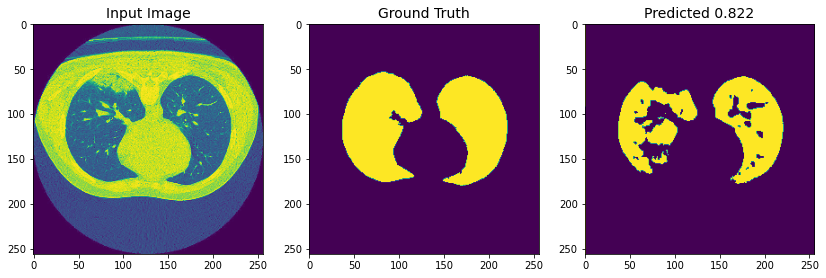

	Batch  1 0.1630769819021225
	Batch  2 0.17136985063552856
	Batch  3 0.1626434326171875
	Batch  4 0.1667138636112213
	Batch  5 0.15819360315799713
	Batch  6 0.15269111096858978
Validation Loss: 0.168, Accuracy: 0.854
Epoch 4 / 10
	Batch 0 loss 0.142
	Batch 1 loss 0.136
	Batch 2 loss 0.137
	Batch 3 loss 0.122
	Batch 4 loss 0.132
	Batch 5 loss 0.124
	Batch 6 loss 0.134
	Batch 7 loss 0.138
	Batch 8 loss 0.120
	Batch 9 loss 0.124
	Batch 10 loss 0.150
	Batch 11 loss 0.137
	Batch 12 loss 0.124
	Batch 13 loss 0.126
	Batch 14 loss 0.130
	Batch 15 loss 0.138
	Batch 16 loss 0.127
	Batch 17 loss 0.126
	Batch 18 loss 0.130
	Batch 19 loss 0.133
	Batch 20 loss 0.119
	Batch 21 loss 0.120
	Batch 22 loss 0.127
	Batch 23 loss 0.116
	Batch 24 loss 0.122
	Batch 25 loss 0.118
	Batch 26 loss 0.118
	Batch 27 loss 0.129
	Batch 28 loss 0.119
	Batch 29 loss 0.114
	Batch 30 loss 0.130
	Batch 31 loss 0.120
	Batch 32 loss 0.124
	Batch 33 loss 0.124
	Batch 34 loss 0.143
	Batch 35 loss 0.115
	Batch 36 loss 0.121
	Ba

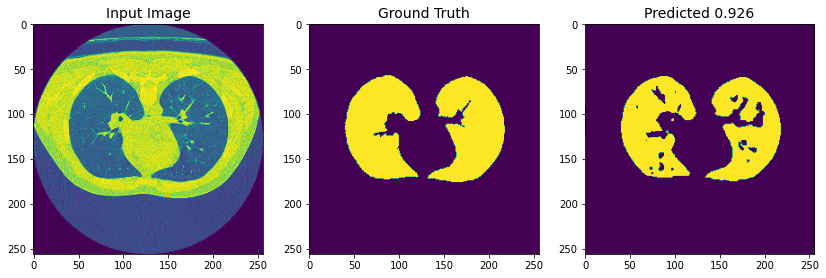

	Batch  1 0.12552878260612488
	Batch  2 0.13117942214012146
	Batch  3 0.14191053807735443
	Batch  4 0.13101983070373535
	Batch  5 0.13532640039920807
	Batch  6 0.10993100702762604
Validation Loss: 0.132, Accuracy: 0.878
Epoch 5 / 10
	Batch 0 loss 0.103
	Batch 1 loss 0.099
	Batch 2 loss 0.120
	Batch 3 loss 0.110
	Batch 4 loss 0.105
	Batch 5 loss 0.112
	Batch 6 loss 0.112
	Batch 7 loss 0.100
	Batch 8 loss 0.103
	Batch 9 loss 0.102
	Batch 10 loss 0.103
	Batch 11 loss 0.098
	Batch 12 loss 0.098
	Batch 13 loss 0.102
	Batch 14 loss 0.103
	Batch 15 loss 0.096
	Batch 16 loss 0.098
	Batch 17 loss 0.105
	Batch 18 loss 0.102
	Batch 19 loss 0.091
	Batch 20 loss 0.098
	Batch 21 loss 0.105
	Batch 22 loss 0.094
	Batch 23 loss 0.099
	Batch 24 loss 0.093
	Batch 25 loss 0.091
	Batch 26 loss 0.102
	Batch 27 loss 0.095
	Batch 28 loss 0.092
	Batch 29 loss 0.103
	Batch 30 loss 0.100
	Batch 31 loss 0.090
	Batch 32 loss 0.099
	Batch 33 loss 0.092
	Batch 34 loss 0.092
	Batch 35 loss 0.093
	Batch 36 loss 0.091


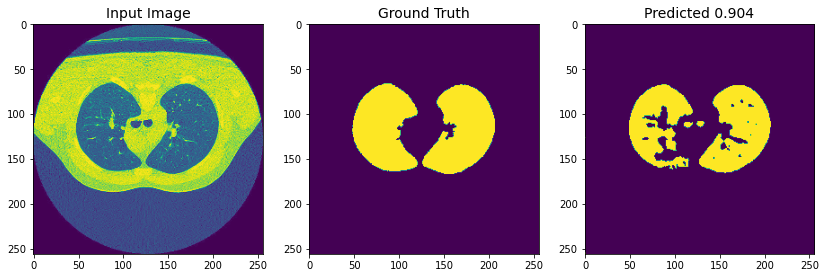

	Batch  1 0.12009523063898087
	Batch  2 0.13294756412506104
	Batch  3 0.12997308373451233
	Batch  4 0.1229361817240715
	Batch  5 0.11365833133459091
	Batch  6 0.14284934103488922
Validation Loss: 0.126, Accuracy: 0.865
Epoch 6 / 10
	Batch 0 loss 0.082
	Batch 1 loss 0.097
	Batch 2 loss 0.080
	Batch 3 loss 0.084
	Batch 4 loss 0.087
	Batch 5 loss 0.078
	Batch 6 loss 0.084
	Batch 7 loss 0.097
	Batch 8 loss 0.077
	Batch 9 loss 0.084
	Batch 10 loss 0.076
	Batch 11 loss 0.079
	Batch 12 loss 0.080
	Batch 13 loss 0.087
	Batch 14 loss 0.083
	Batch 15 loss 0.090
	Batch 16 loss 0.091
	Batch 17 loss 0.078
	Batch 18 loss 0.075
	Batch 19 loss 0.079
	Batch 20 loss 0.082
	Batch 21 loss 0.074
	Batch 22 loss 0.075
	Batch 23 loss 0.078
	Batch 24 loss 0.080
	Batch 25 loss 0.080
	Batch 26 loss 0.082
	Batch 27 loss 0.074
	Batch 28 loss 0.077
	Batch 29 loss 0.073
	Batch 30 loss 0.077
	Batch 31 loss 0.070
	Batch 32 loss 0.082
	Batch 33 loss 0.070
	Batch 34 loss 0.072
	Batch 35 loss 0.076
	Batch 36 loss 0.070
	

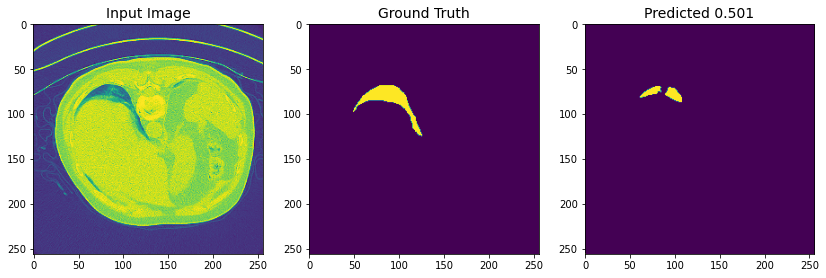

	Batch  1 0.13747620582580566
	Batch  2 0.1383609175682068
	Batch  3 0.12084761261940002
	Batch  4 0.11862626671791077
	Batch  5 0.13264517486095428
	Batch  6 0.09342893958091736
Validation Loss: 0.126, Accuracy: 0.852
Epoch 7 / 10
	Batch 0 loss 0.068
	Batch 1 loss 0.089
	Batch 2 loss 0.069
	Batch 3 loss 0.065
	Batch 4 loss 0.065
	Batch 5 loss 0.065
	Batch 6 loss 0.076
	Batch 7 loss 0.076
	Batch 8 loss 0.074
	Batch 9 loss 0.065
	Batch 10 loss 0.069
	Batch 11 loss 0.065
	Batch 12 loss 0.070
	Batch 13 loss 0.066
	Batch 14 loss 0.068
	Batch 15 loss 0.066
	Batch 16 loss 0.069
	Batch 17 loss 0.068
	Batch 18 loss 0.067
	Batch 19 loss 0.062
	Batch 20 loss 0.071
	Batch 21 loss 0.072
	Batch 22 loss 0.066
	Batch 23 loss 0.069
	Batch 24 loss 0.065
	Batch 25 loss 0.066
	Batch 26 loss 0.062
	Batch 27 loss 0.065
	Batch 28 loss 0.062
	Batch 29 loss 0.064
	Batch 30 loss 0.074
	Batch 31 loss 0.061
	Batch 32 loss 0.058
	Batch 33 loss 0.062
	Batch 34 loss 0.065
	Batch 35 loss 0.061
	Batch 36 loss 0.065
	

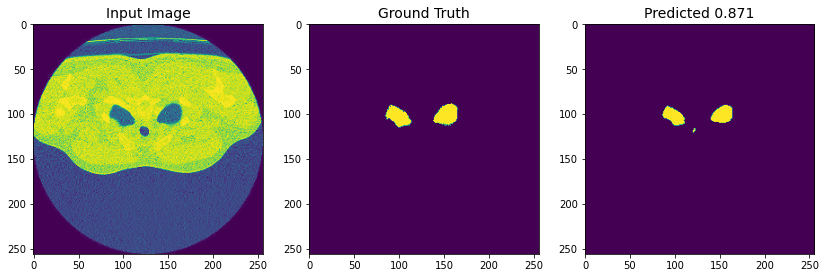

	Batch  1 0.13457588851451874
	Batch  2 0.13159382343292236
	Batch  3 0.09877897053956985
	Batch  4 0.10632836073637009
	Batch  5 0.12579061090946198
	Batch  6 0.1407211869955063
Validation Loss: 0.118, Accuracy: 0.860
Epoch 8 / 10
	Batch 0 loss 0.059
	Batch 1 loss 0.060
	Batch 2 loss 0.061
	Batch 3 loss 0.055
	Batch 4 loss 0.057
	Batch 5 loss 0.055
	Batch 6 loss 0.066
	Batch 7 loss 0.067
	Batch 8 loss 0.058
	Batch 9 loss 0.057
	Batch 10 loss 0.057
	Batch 11 loss 0.055
	Batch 12 loss 0.059
	Batch 13 loss 0.055
	Batch 14 loss 0.060
	Batch 15 loss 0.056
	Batch 16 loss 0.058
	Batch 17 loss 0.063
	Batch 18 loss 0.061
	Batch 19 loss 0.059
	Batch 20 loss 0.052
	Batch 21 loss 0.057
	Batch 22 loss 0.053
	Batch 23 loss 0.054
	Batch 24 loss 0.056
	Batch 25 loss 0.058
	Batch 26 loss 0.056
	Batch 27 loss 0.052
	Batch 28 loss 0.054
	Batch 29 loss 0.053
	Batch 30 loss 0.052
	Batch 31 loss 0.054
	Batch 32 loss 0.052
	Batch 33 loss 0.057
	Batch 34 loss 0.051
	Batch 35 loss 0.058
	Batch 36 loss 0.050
	

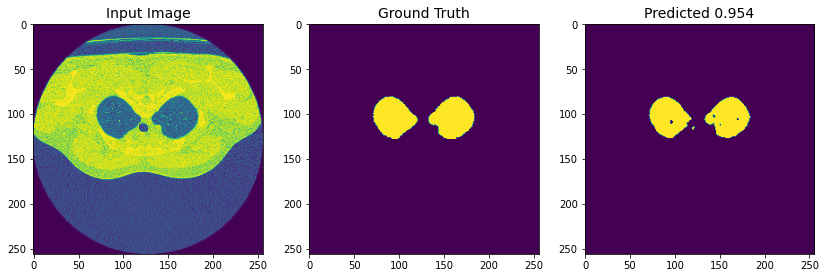

	Batch  1 0.1013723611831665
	Batch  2 0.1053154319524765
	Batch  3 0.08954166620969772
	Batch  4 0.10582565516233444
	Batch  5 0.09622419625520706
	Batch  6 0.08681613206863403
Validation Loss: 0.098, Accuracy: 0.890
Epoch 9 / 10
	Batch 0 loss 0.050
	Batch 1 loss 0.058
	Batch 2 loss 0.050
	Batch 3 loss 0.049
	Batch 4 loss 0.051
	Batch 5 loss 0.046
	Batch 6 loss 0.048
	Batch 7 loss 0.052
	Batch 8 loss 0.055
	Batch 9 loss 0.047
	Batch 10 loss 0.050
	Batch 11 loss 0.048
	Batch 12 loss 0.051
	Batch 13 loss 0.045
	Batch 14 loss 0.050
	Batch 15 loss 0.047
	Batch 16 loss 0.054
	Batch 17 loss 0.049
	Batch 18 loss 0.049
	Batch 19 loss 0.048
	Batch 20 loss 0.048
	Batch 21 loss 0.051
	Batch 22 loss 0.045
	Batch 23 loss 0.047
	Batch 24 loss 0.047
	Batch 25 loss 0.055
	Batch 26 loss 0.071
	Batch 27 loss 0.050
	Batch 28 loss 0.050
	Batch 29 loss 0.054
	Batch 30 loss 0.050
	Batch 31 loss 0.051
	Batch 32 loss 0.061
	Batch 33 loss 0.045
	Batch 34 loss 0.051
	Batch 35 loss 0.045
	Batch 36 loss 0.051
	B

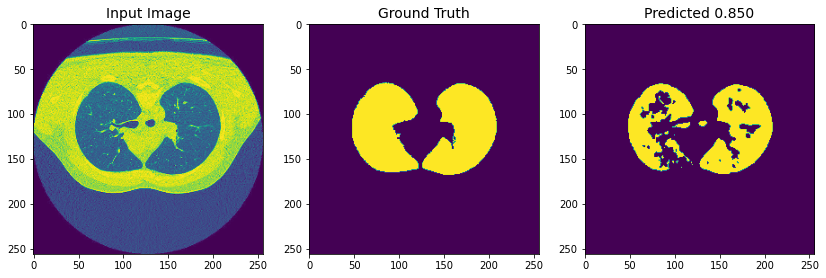

	Batch  1 0.10710813850164413
	Batch  2 0.08263018727302551
	Batch  3 0.0992131233215332
	Batch  4 0.09574532508850098
	Batch  5 0.10243074595928192
	Batch  6 0.1234852522611618
Validation Loss: 0.098, Accuracy: 0.876


In [34]:
train_accuracy = []
train_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):
 
    #
    # Training Loop
    #

    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.train()

    # Batch Training Loop (Loop over the batches)
    for index, (X, Y) in enumerate(train_Lung_dataloader):
        
        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        # Compute the loss
        L = loss(R, Y.long())

        # Do PyTorch stuff - Training 
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        pred = R.data.max(1)[1]
        
        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_loss += L.data.item() * X.shape[0]
        print(f'\tBatch {index} loss {L.data.item():3.3f}')
        
        epoch_counter += X.shape[0]
  
    # Epoch Train Loss
    train_accuracy.append(epoch_accuracy/epoch_counter)
    train_loss.append(epoch_loss/epoch_counter)
    print(f"Loss: {train_loss[-1]:3.3f}, Accuracy: {train_accuracy[-1]:3.3f}")
    
    #
    # Validation Loop 
    #
   
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.eval()
    
    # Batch Validation Loop (Loop over the batches)
    with torch.no_grad():
        for index, (X, Y) in enumerate(val_Lung_dataloader):

            if device is not None:
                X = X.to(device)
                Y = Y.to(device)

            # Call the model (image to mask)
            R = model(X)

            # Compute the loss
            L = loss(R, Y.long())

            pred = R.data.max(1)[1]

            # Analyze the accuracy of the batch 
            epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
            epoch_loss += L.data.item() * X.shape[0]
            print('\tBatch ', index, L.data.item())

            if index == 0:
                plt.figure(figsize=[14, 7])
                plt.subplot(1,3,1)
                plt.imshow(X[0, 0].cpu().detach().numpy())
                plt.title('Input Image', fontsize=14)
                plt.subplot(1,3,2)
                plt.imshow(Y[0].cpu().detach().numpy())
                plt.title('Ground Truth', fontsize=14)
                plt.subplot(1,3,3)
                plt.imshow(pred[0].cpu().detach().numpy())
                plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
                plt.show()

            epoch_counter += X.shape[0]

    # Epoch Train Loss
    validation_accuracy.append(epoch_accuracy/epoch_counter)
    validation_loss.append(epoch_loss/epoch_counter)
    print(f"Validation Loss: {validation_loss[-1]:3.3f}, Accuracy: {validation_accuracy[-1]:3.3f}")
    

# Plot Loss and Accuracy Curves (Lung Mask)



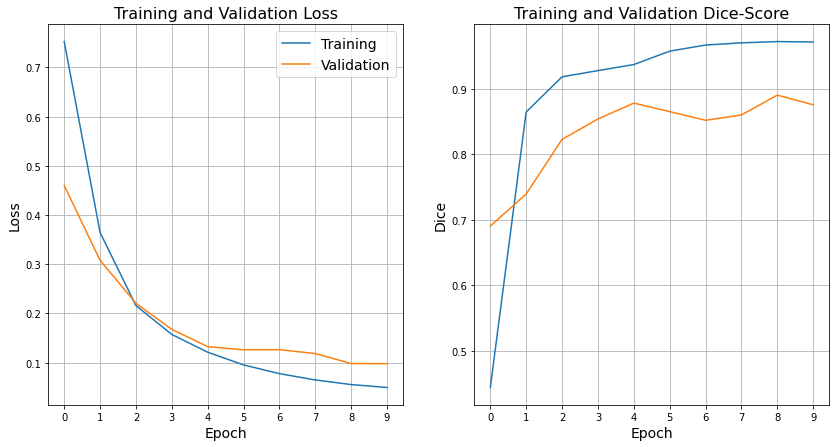

In [35]:
# Display Train and Validation Loss and Dice scores

fig = plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.xticks(range(epochs))
plt.grid('on')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xticks(range(epochs))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Dice', fontsize=14)
plt.title('Training and Validation Dice-Score', fontsize=16)
plt.grid('on')

# Run Neural Network on Test Data (Lung Mask)

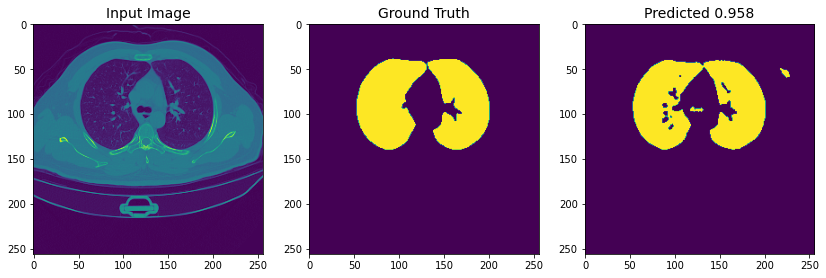

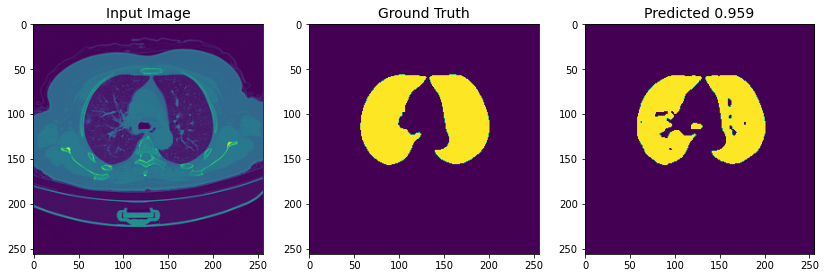

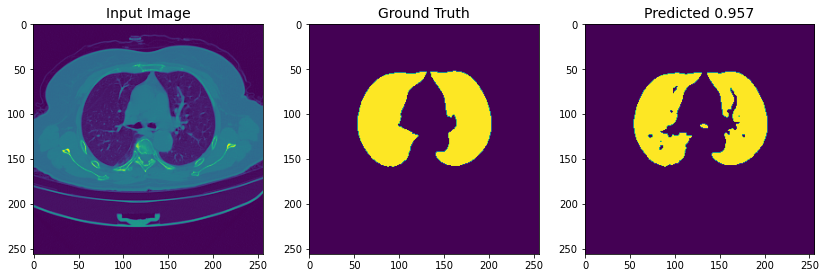

Test Accuracy: 0.958


In [37]:
model.eval()

test_accuracy = []
test_loss = []
epoch_accuracy = 0
epoch_counter = 0

model.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test_Lung_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        plt.figure(figsize=[14, 7])
        plt.title('Lung Segmentation using Neural Network')
        plt.subplot(1,3,1)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.title('Input Image', fontsize=14)
        plt.subplot(1,3,2)
        plt.imshow(Y[0].cpu().detach().numpy())
        plt.title('Ground Truth', fontsize=14)
        plt.subplot(1,3,3)
        plt.imshow(pred[0].cpu().detach().numpy())
        plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
        plt.show()

    # Epoch Train Loss
    test_accuracy.append(epoch_accuracy/epoch_counter)
    test_loss.append(epoch_loss/epoch_counter)
    print(f"Test Accuracy: {test_accuracy[-1]:3.3f}")

# Comparison with threshold-based segmentation

In [45]:
test100_file_slices = read_slices(test_filenames)
test100_file_slices = random.choices(test100_file_slices, k=3)

In [48]:
test100_Lung_dataset = LungDataset(test100_file_slices, test_transform)
test100_Lung_dataloader = DataLoader(test100_Lung_dataset, batch_size=1, num_workers=0, shuffle=False) 

161
1.6609248060079231
-777
1.6609248060079231


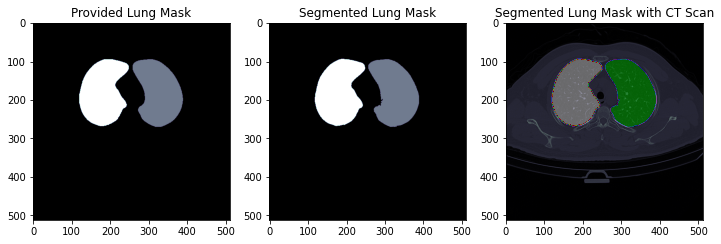

In [70]:
fn, fn_lung_mask, fn_infection_mask, sl = test100_file_slices[2]
# print(f'{val_file_slices[5]}')
print(sl)
# Load the data using the loading function that will be used later
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)
struct = generate_binary_structure(2, 1)
i = 0
temp = 0
# thres_num = -100 # initial threshold number, start from a number that is not good
dice_array = []
max_dice = -1000
s_thres = 0
for thres_num in range(-1000,0):
  thresholded = strip_skull(sample_ct) < thres_num # (sample_ct > -191)
  lungs = clear_border(thresholded)
  largest = largest_connected_component(lungs)
  largest_2 = second_largest_connected_component(lungs)
  largest = largest*2
  larges = largest + largest_2
  lung_dilate1 = binary_dilation(largest,struct)
  lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
  lung_dilate1 = lung_dilate1 * 2

  lung_dilate2 = binary_dilation(largest_2,struct)
  lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
  lung_total = lung_dilate1 + lung_dilate2
  new_dice = dice_coef(sample_lung_mask,lung_total)
  tuplething = [thres_num, new_dice]
  dice_array.append(tuplething)
  if max_dice < new_dice:
    max_dice = new_dice
    s_thres = thres_num
print(max_dice)
print(s_thres)
thresholded = strip_skull(sample_ct) < s_thres 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2

print(dice_coef(sample_lung_mask,lung_total))
dice_array = np.asarray(dice_array)

0.9925948876954378
0.9447558816311826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


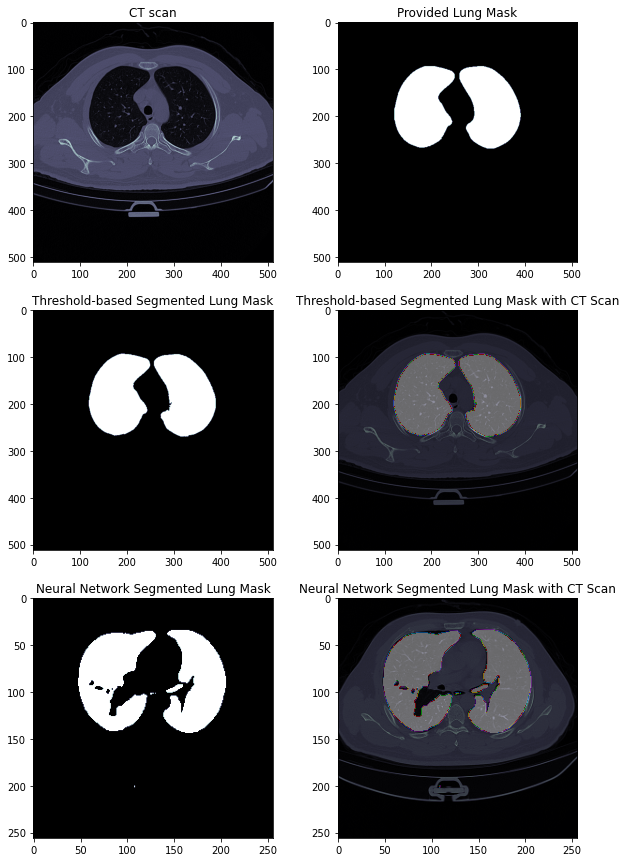

0.9925948876954378
0.866726982624212


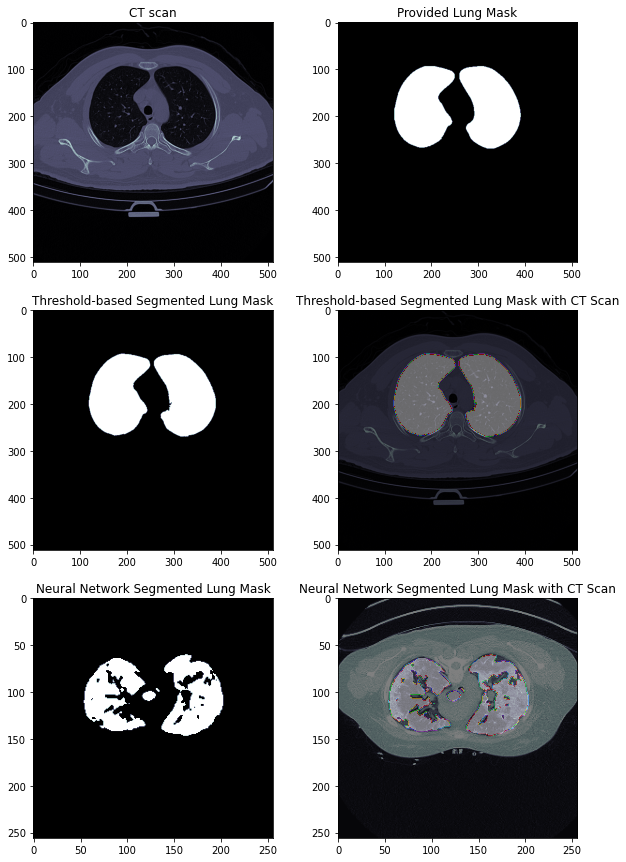

0.9925948876954378
0.9781954888584242


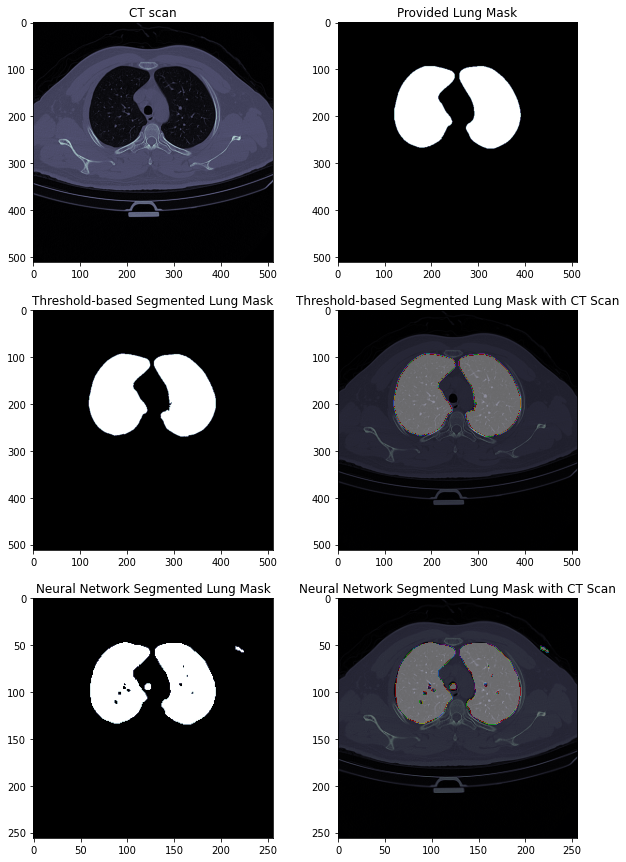

Test Accuracy: 0.930


In [71]:
model.eval()

test_accuracy = []
test_loss = []
epoch_accuracy = 0
epoch_counter = 0

model.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test100_Lung_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        print(dice_coef(sample_lung_mask.astype(bool),lung_total.astype(bool)))
        print(dice_coef(pred[0], Y[0]))

        fig = plt.figure(figsize = (10,15))
        plt.subplot(3,2,1)
        plt.imshow(sample_ct, cmap = 'bone')
        plt.title('CT scan')

        plt.subplot(3,2,2)
        plt.imshow(sample_lung_mask.astype(bool), cmap = 'bone')
        plt.title('Provided Lung Mask')

        plt.subplot(3,2,3)
        plt.imshow(lung_total.astype(bool), cmap = 'bone')
        plt.title('Threshold-based Segmented Lung Mask')

        plt.subplot(3,2,4)
        plt.imshow(sample_ct, cmap = 'bone')
        plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
        plt.title('Threshold-based Segmented Lung Mask with CT Scan')

        plt.subplot(3,2,3)
        plt.imshow(lung_total.astype(bool), cmap = 'bone')
        plt.title('Threshold-based Segmented Lung Mask')

        plt.subplot(3,2,4)
        plt.imshow(sample_ct, cmap = 'bone')
        plt.imshow(lung_total.astype(bool),alpha = 0.5, cmap = 'nipy_spectral')
        plt.title('Threshold-based Segmented Lung Mask with CT Scan')

        plt.subplot(3,2,5)
        plt.imshow(pred[0].cpu().detach().numpy(),cmap = 'bone')
        plt.title(f'Neural Network Segmented Lung Mask')
        
        plt.subplot(3,2,6)
        plt.imshow(X[0, 0].cpu().detach().numpy(), cmap = 'bone')
        plt.imshow(pred[0].cpu().detach().numpy(),alpha = 0.5 ,cmap = 'nipy_spectral')
        plt.title(f'Neural Network Segmented Lung Mask with CT Scan')


        plt.show()

    # Epoch Train Loss
    test_accuracy.append(epoch_accuracy/epoch_counter)
    test_loss.append(epoch_loss/epoch_counter)
    print(f"Test Accuracy: {test_accuracy[-1]:3.3f}")